In [92]:
import numpy as np
import pickle

# G-code generation codes are cloned from https://github.com/tibor-barsi/GcodeGenerator. Tibor Barsi is the author of the code, and was a PhD student at the Ladisk lab of the University of Ljubljana
#  We should be careful with crediting the author of the code, if we ever want to make these code public.
from src.g_code_generation_copy.gcode_generator import G_code_generator
from src.g_code_generation_copy.tool_changer_functions import save_params, load_params, printer_start, load_tool, unload_tool, tool_change, take_photo, play_sound, printer_stop
# from src.additional_functions import *
from src.network import Network_custom, replace_brackets
import os

BYU_UW_root = r"G:\.shortcut-targets-by-id\1k1B8zPb3T8H7y6x0irFZnzzmfQPHMRPx\Illimited Lab Projects\Research Projects\Spiders\BYU-UW"

In [93]:
def generate_snake_path(n, W, L, w_offset, h_offset, z):
    lines = []
    total_length = 0
    spacing = (L-2*h_offset) / (n)
    for i in range(n):
        offset0 = 2*i * spacing/2 + h_offset
        offset1 = (2*i+1) * spacing/2 + h_offset
        offset2 = (2*i+2) * spacing/2 + h_offset
        line = [
            [w_offset, offset0, z],  # start point
            [W-w_offset, offset0, z],  # point at a% of the line
            [W-w_offset, offset1, z],  # point at b% of the line
            [w_offset, offset1, z],
            [w_offset, offset2, z]    # end point
        ]
        lines.append(line)
        total_length += 2*(W-2*w_offset) + (offset2 - offset1) + (offset1 - offset0)
    return lines, int(np.round(total_length))

# Example usage

bed_width = 190
bed_height = 230
n = 100
a = 0.25
b = 0.75
z = .3
w_offset = 5
h_offset = 5
x_offset = 0.5

snake_lines, total_length = generate_snake_path(n, bed_width, bed_height, w_offset, h_offset, z)
total_length

36220

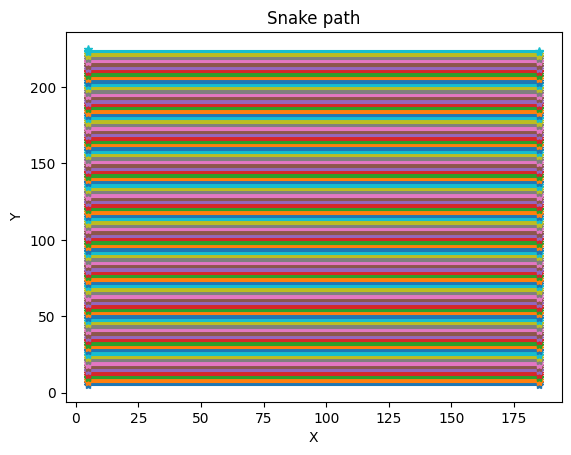

In [94]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()

for line in snake_lines:
    x_values = [point[0] for point in line]
    y_values = [point[1] for point in line]
    ax.plot(x_values, y_values, '-*')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Snake path')
plt.show()

In [95]:
def print_snake_line_section(snake_lines, ef, comment):
    """
    Print a parallel line
    
        Parameters
        ----------
        snake_lines : list
            List of 5 points that define the snake line section
        ef : float
                Extrude factor for the full section
        comment : str
                Comment to be added to the g-code
    """
    g_code = ''
    g_code += gen._print_line(
        point0=snake_lines[0],
        point1=snake_lines[1],
        move_to_start=False, # move to start point without extruding
        extrude_factor=ef,
        comment=comment)
    g_code += gen._print_line(
        point0=snake_lines[1],
        point1=snake_lines[2],
        move_to_start=False, # move to start point without extruding
        extrude_factor=ef,
        comment=comment)
    g_code += gen._print_line(
        point0=snake_lines[2],
        point1=snake_lines[3],
        move_to_start=False, # move to start point without extruding
        extrude_factor=ef,
        comment=comment)
    g_code += gen._print_line(
        point0=snake_lines[3],
        point1=snake_lines[4],
        move_to_start=False, # move to start point without extruding
        extrude_factor=ef,
        comment=comment)
    return g_code

In [96]:
printing_params = load_params(r'DATA/NT_Eel_0.2mm_og.json')
start_gcode     = open(r'DATA/start_gcode.gcode', 'r').read()
end_gcode       = open(r'DATA/end_gcode.gcode', 'r').read()

pause_time = 10 # seconds

temperature_settings = {'first_layer_bed_temperature': 65, 'first_layer_temperature':205, 'K-factor': 0.20}
g_code = replace_brackets(start_gcode, temperature_settings)

ef = printing_params['extrude_factor']
gen = G_code_generator(printing_params=printing_params)

## Add a Purge line
point0, point1 = [h_offset//2,50, z], [h_offset//2,150, z]
g_code += gen.move_to_point(point0[0:2], point0[2] + printing_params['nozzle_lift'], comment='Move to start point')
g_code += gen.move_to_point(point0[0:2], point0[2], comment='Lower Nozzle')
g_code += gen.unretract()
g_code += gen._print_line(
        point0=point0,
        point1=point1,
        move_to_start=False, # move to start point without extruding
        extrude_factor=printing_params['extrude_factor']*2,
        comment="PURGE LINE")
g_code += gen.retract()
g_code += gen.wipe(np.pi) # Wipe the nozzle horizontally

## Pause the printer to measure filament length

g_code += gen.move_to_point([point1[0], point1[1]], point1[2] + printing_params['nozzle_lift']*5, comment='Lift Nozzle')
g_code += f"G4 S{pause_time}\n"

## Start printing the snake path
g_code += gen.move_to_point(snake_lines[0][0][0:2], snake_lines[0][0][2] + printing_params['nozzle_lift'], comment='Move to start point')
g_code += gen.move_to_point(snake_lines[0][0][0:2], snake_lines[0][0][2], comment='Lower Nozzle')
g_code += gen.unretract()

for snake_line_section in snake_lines:
    g_code += print_snake_line_section(snake_line_section, ef, 'Snake path')

g_code += gen.retract()
g_code += gen.wipe_from_last_points(g_code)

model_name = f'SnakePath_L{int(total_length)}mm'
with open(os.path.join(BYU_UW_root, 'GCODE', model_name + '.gcode'), "w") as g_code_file:
    g_code_file.write(g_code)
print('G-code generated')

G-code generated
